# Vector-to-Vector Network & Training

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import collections
from collections import OrderedDict

## User Inputs

In [2]:
infile = 'vtov_dataset.npz'
batch_size = 250
n_epochs = 500
hidden_layers = [(1,6)]
valid_size = 2000
model_path = 'vtov_model_6nodes'
fig_path = 'vtov_fig_6nodes.png'
fig2_path = 'vtovfig_6nodes_zoom.png'
df_path = 'vtov_df_6nodes'
seed = 12345

## Loading Data

In [3]:
npfile = np.load(infile)
inputs = npfile['inputs']
outputs = npfile['outputs']

In [4]:
# standardizing inputs, outputs and coverting to tensors
inputMeans = inputs[0:int(inputs.shape[0]),:].mean(axis=0)
inputStdDevs = inputs[0:int(inputs.shape[0]),:].std(axis=0)
inputs = (inputs-inputMeans)/inputStdDevs
inputs = torch.from_numpy(inputs).float()

outputMeans = outputs[0:int(outputs.shape[0]),:].mean(axis=0)
outputStdDevs = outputs[0:int(outputs.shape[0]),:].std(axis=0)
outputs = (outputs-outputMeans)/outputStdDevs
outputs = torch.from_numpy(outputs).float()

In [5]:
# generating a TensorDataset for training
trainset = torch.utils.data.TensorDataset(inputs, outputs)

## Network Definition

In [6]:
# input, output sizes
out_size = list(outputs[0].size())[0]
in_size = list(inputs[0].size())[0]

# number of hidden layers
num = len(hidden_layers)

# number of nodes in a given hidden layer
def nodes(i):
    layer = hidden_layers[i]
    dim_node = layer[1]
    return dim_node

In [7]:
network = OrderedDict([])

network = OrderedDict([('lin1', nn.Linear(in_size, nodes(0))),('relu1', nn.ReLU())]) 
if num > 1:
    for i in range(1, num):
        network['lin{index}'.format(index=i+1)] = nn.Linear(nodes(i-1), nodes(i))
        network['relu{index}'.format(index=i+1)] = nn.ReLU()
network['lin{index}'.format(index=num+1)] = nn.Linear(nodes(num-1), out_size)    

model = nn.Sequential(network)

## Function Definitions

In [8]:
# defines the training process for one epoch, returns training loss for given epoch
def train(model, loader, optimizer, criterion):
    running_train_loss = 0.0

    # put model into train mode
    model.train()

    for batch_idx, (inputs, outputs) in enumerate(loader):
        inputs_var = inputs
        outputs_var = outputs
        
        # get model output & loss for each given input
        model_outputs = model(inputs_var)
        loss = criterion(model_outputs, outputs_var)

        # record cummulative loss
        running_train_loss += loss.item()

        # gradient, optimizer steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return running_train_loss


# defines the validation process for one epoch, returns validation loss for given epoch
def validate(model, loader, criterion):
    running_valid_loss = 0.0

    # put model in evaluation mode
    model.eval()

    for batch_idx, (inputs, outputs) in enumerate(loader):
        with torch.no_grad():
            inputs_var = inputs
            outputs_var = outputs

            # get model output & loss for each given input
            model_outputs = model(inputs_var)
            loss = criterion(model_outputs, outputs_var)

        # record cummulative loss
        running_valid_loss += loss.item()

    return running_valid_loss


# runs training and validation process over all epochs, returns results
def run_training(model, modelpath, figpath, fig2path, dfpath, trainset, validsize, numepochs, batchsize, seed):
    # set seed
    torch.manual_seed(seed)

    # create validation split
    indices = torch.randperm(len(train_set))
    train_indices = indices[:len(indices) - valid_size]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    valid_indices = indices[len(indices) - valid_size:]
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

    # define data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler)
  
    # set criterion, optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    # store results
    best_model = copy.deepcopy(model.state_dict())
    train_loss_results = []
    valid_loss_results = []
    epochs = []
    
    # train model
    for epoch in enumerate(range(n_epochs)):
        trainloss = train(model=model,loader=train_loader,criterion=criterion,optimizer=optimizer)
        print('train loss for epoch {index} attained: {loss}'.format(index=epoch[0], loss=train_loss))
        
        validloss = validate(model=model,loader=valid_loader,criterion=criterion)
        print('valid loss for epoch {index} attained: {loss}'.format(index=epoch[0], loss=valid_loss))
        
        train_loss_results.append(trainloss)
        valid_loss_results.append(validloss)
        epochs.append(epoch[0]+1)
        
        # check if model is the best, save if best
        if epoch[0] == 0:
            bestloss = validloss

        if epoch[0] > 0:
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = copy.deepcopy(model)
                best_epoch = epoch[0]
                print('new best model saved')
                
        print('epoch {index} done'.format(index=epoch[0]))
        
    print('finished looping epochs')
    print('best valid loss = {}, epoch {}'.format(bestloss, best_epoch))

    # load and save the best model
    torch.save(best_model, model_path)
    print('best model loaded and saved')

    # plot training & validation loss vs. epoch
    plt.plot(epochs, train_loss_results)
    plt.plot(epochs, valid_loss_results)
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.title('Model Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    plt.savefig(fig_path)
    print('plot saved')
    
    # plot training & validation loss vs. epoch -- scale 2
    plt.plot(epochs, train_loss_results)
    plt.plot(epochs, valid_loss_results)
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.title('Model Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0,0.00004)
    plt.show()
    plt.savefig('fig2_path')
    print('plot saved')
    
    # create dataframe of epochs, losses
    d = {'trainloss':train_loss_results, 'validloss':valid_loss_results}
    df = pd.DataFrame(d, index=epochs)
    df.to_csv(df_path)
    print('dataframe saved')
    
    return

## Run Training Function

train_loss for epoch 0 attained: 47.04493260383606
valid_loss for epoch 0 attained: 11.019710898399353
resuts updated
best_loss set to valid_loss for epoch 0
epoch 0 done
train_loss for epoch 1 attained: 42.49616527557373
valid_loss for epoch 1 attained: 10.02976679801941
resuts updated
new best model saved
epoch 1 done
train_loss for epoch 2 attained: 38.891831040382385
valid_loss for epoch 2 attained: 9.229357481002808
resuts updated
new best model saved
epoch 2 done
train_loss for epoch 3 attained: 35.913766860961914
valid_loss for epoch 3 attained: 8.557355761528015
resuts updated
new best model saved
epoch 3 done
train_loss for epoch 4 attained: 33.385526061058044
valid_loss for epoch 4 attained: 7.98123824596405
resuts updated
new best model saved
epoch 4 done
train_loss for epoch 5 attained: 31.198374092578888
valid_loss for epoch 5 attained: 7.473673462867737
resuts updated
new best model saved
epoch 5 done
train_loss for epoch 6 attained: 29.22932779788971
valid_loss for epoch

valid_loss for epoch 53 attained: 0.04129569139331579
resuts updated
new best model saved
epoch 53 done
train_loss for epoch 54 attained: 0.15650051459670067
valid_loss for epoch 54 attained: 0.039110812824219465
resuts updated
new best model saved
epoch 54 done
train_loss for epoch 55 attained: 0.14827358722686768
valid_loss for epoch 55 attained: 0.03715396556071937
resuts updated
new best model saved
epoch 55 done
train_loss for epoch 56 attained: 0.14099799282848835
valid_loss for epoch 56 attained: 0.035372906597331166
resuts updated
new best model saved
epoch 56 done
train_loss for epoch 57 attained: 0.1342425742186606
valid_loss for epoch 57 attained: 0.03372290963307023
resuts updated
new best model saved
epoch 57 done
train_loss for epoch 58 attained: 0.1282838995102793
valid_loss for epoch 58 attained: 0.03225802234373987
resuts updated
new best model saved
epoch 58 done
train_loss for epoch 59 attained: 0.12272686348296702
valid_loss for epoch 59 attained: 0.0308989703189581

valid_loss for epoch 106 attained: 0.008932699100114405
resuts updated
new best model saved
epoch 106 done
train_loss for epoch 107 attained: 0.033841236669104546
valid_loss for epoch 107 attained: 0.008676671946886927
resuts updated
new best model saved
epoch 107 done
train_loss for epoch 108 attained: 0.032774249906651676
valid_loss for epoch 108 attained: 0.008421604987233877
resuts updated
new best model saved
epoch 108 done
train_loss for epoch 109 attained: 0.03178817144362256
valid_loss for epoch 109 attained: 0.008178819669410586
resuts updated
new best model saved
epoch 109 done
train_loss for epoch 110 attained: 0.030845703382510692
valid_loss for epoch 110 attained: 0.007918344694189727
resuts updated
new best model saved
epoch 110 done
train_loss for epoch 111 attained: 0.02989333972800523
valid_loss for epoch 111 attained: 0.0076704121311195195
resuts updated
new best model saved
epoch 111 done
train_loss for epoch 112 attained: 0.028959562710952014
valid_loss for epoch 11

train_loss for epoch 157 attained: 0.0012203250898892293
valid_loss for epoch 157 attained: 0.0003670219812192954
resuts updated
new best model saved
epoch 157 done
train_loss for epoch 158 attained: 0.0010942032531602308
valid_loss for epoch 158 attained: 0.0003367209192219889
resuts updated
new best model saved
epoch 158 done
train_loss for epoch 159 attained: 0.000987214039923856
valid_loss for epoch 159 attained: 0.00030754649014852475
resuts updated
new best model saved
epoch 159 done
train_loss for epoch 160 attained: 0.0008880272989699733
valid_loss for epoch 160 attained: 0.0002814853432937525
resuts updated
new best model saved
epoch 160 done
train_loss for epoch 161 attained: 0.0008018039688977296
valid_loss for epoch 161 attained: 0.0002597043976493296
resuts updated
new best model saved
epoch 161 done
train_loss for epoch 162 attained: 0.0007274321242221049
valid_loss for epoch 162 attained: 0.0002413998754491331
resuts updated
new best model saved
epoch 162 done
train_loss

train_loss for epoch 207 attained: 3.818272200462047e-05
valid_loss for epoch 207 attained: 2.9497562408664635e-05
resuts updated
new best model saved
epoch 207 done
train_loss for epoch 208 attained: 3.605556783270458e-05
valid_loss for epoch 208 attained: 2.8288294153355764e-05
resuts updated
new best model saved
epoch 208 done
train_loss for epoch 209 attained: 3.4045753610101315e-05
valid_loss for epoch 209 attained: 2.738109587596682e-05
resuts updated
new best model saved
epoch 209 done
train_loss for epoch 210 attained: 3.2103234385516544e-05
valid_loss for epoch 210 attained: 2.644539810603419e-05
resuts updated
new best model saved
epoch 210 done
train_loss for epoch 211 attained: 3.02501483062656e-05
valid_loss for epoch 211 attained: 2.5502057781068288e-05
resuts updated
new best model saved
epoch 211 done
train_loss for epoch 212 attained: 2.853179564343833e-05
valid_loss for epoch 212 attained: 2.471011699611836e-05
resuts updated
new best model saved
epoch 212 done
train_

train_loss for epoch 257 attained: 2.156587420143463e-06
valid_loss for epoch 257 attained: 7.920749629186652e-06
resuts updated
new best model saved
epoch 257 done
train_loss for epoch 258 attained: 2.057118612064368e-06
valid_loss for epoch 258 attained: 7.772236572278768e-06
resuts updated
new best model saved
epoch 258 done
train_loss for epoch 259 attained: 1.944314338808706e-06
valid_loss for epoch 259 attained: 7.646810140649052e-06
resuts updated
new best model saved
epoch 259 done
train_loss for epoch 260 attained: 1.865453301885811e-06
valid_loss for epoch 260 attained: 7.496142248597515e-06
resuts updated
new best model saved
epoch 260 done
train_loss for epoch 261 attained: 1.7552072332782664e-06
valid_loss for epoch 261 attained: 7.372721236853508e-06
resuts updated
new best model saved
epoch 261 done
train_loss for epoch 262 attained: 1.6757354960872384e-06
valid_loss for epoch 262 attained: 7.277897400181921e-06
resuts updated
new best model saved
epoch 262 done
train_lo

valid_loss for epoch 307 attained: 4.074104885287699e-06
resuts updated
new best model saved
epoch 307 done
train_loss for epoch 308 attained: 1.8560950517526598e-07
valid_loss for epoch 308 attained: 4.021920731372974e-06
resuts updated
new best model saved
epoch 308 done
train_loss for epoch 309 attained: 1.7226341372106324e-07
valid_loss for epoch 309 attained: 3.977244155288495e-06
resuts updated
new best model saved
epoch 309 done
train_loss for epoch 310 attained: 1.5928107575252648e-07
valid_loss for epoch 310 attained: 3.950897595202119e-06
resuts updated
new best model saved
epoch 310 done
train_loss for epoch 311 attained: 1.5624343574494048e-07
valid_loss for epoch 311 attained: 3.909764099474522e-06
resuts updated
new best model saved
epoch 311 done
train_loss for epoch 312 attained: 1.4623941107030913e-07
valid_loss for epoch 312 attained: 3.886656320006843e-06
resuts updated
new best model saved
epoch 312 done
train_loss for epoch 313 attained: 1.4722185534554733e-07
vali

train_loss for epoch 358 attained: 6.601129418637441e-07
valid_loss for epoch 358 attained: 2.9528806886891523e-06
resuts updated
new best model saved
epoch 358 done
train_loss for epoch 359 attained: 4.4874990740018106e-07
valid_loss for epoch 359 attained: 2.9697720416166362e-06
resuts updated
epoch 359 done
train_loss for epoch 360 attained: 2.0387528071319494e-07
valid_loss for epoch 360 attained: 2.933369084912041e-06
resuts updated
new best model saved
epoch 360 done
train_loss for epoch 361 attained: 5.255524479497176e-07
valid_loss for epoch 361 attained: 2.9660511624562957e-06
resuts updated
epoch 361 done
train_loss for epoch 362 attained: 8.047846373759882e-07
valid_loss for epoch 362 attained: 3.4490004381382278e-06
resuts updated
epoch 362 done
train_loss for epoch 363 attained: 6.41540383927719e-07
valid_loss for epoch 363 attained: 2.9407679784654306e-06
resuts updated
epoch 363 done
train_loss for epoch 364 attained: 2.0402501543781426e-07
valid_loss for epoch 364 attai

train_loss for epoch 414 attained: 8.091601919058e-08
valid_loss for epoch 414 attained: 2.814587251709355e-06
resuts updated
epoch 414 done
train_loss for epoch 415 attained: 2.9547426325104986e-08
valid_loss for epoch 415 attained: 2.804986649063146e-06
resuts updated
epoch 415 done
train_loss for epoch 416 attained: 7.687247755017168e-08
valid_loss for epoch 416 attained: 2.890267724708906e-06
resuts updated
epoch 416 done
train_loss for epoch 417 attained: 2.4572686836421553e-06
valid_loss for epoch 417 attained: 3.829658481890874e-06
resuts updated
epoch 417 done
train_loss for epoch 418 attained: 6.383446271129856e-06
valid_loss for epoch 418 attained: 1.1909763429684972e-05
resuts updated
epoch 418 done
train_loss for epoch 419 attained: 9.026637961540018e-06
valid_loss for epoch 419 attained: 3.303442809965418e-06
resuts updated
epoch 419 done
train_loss for epoch 420 attained: 1.404288125783637e-06
valid_loss for epoch 420 attained: 2.9175860412067323e-06
resuts updated
epoch 

train_loss for epoch 470 attained: 4.210178830565958e-09
valid_loss for epoch 470 attained: 2.784045302163529e-06
resuts updated
epoch 470 done
train_loss for epoch 471 attained: 3.6857806130080606e-09
valid_loss for epoch 471 attained: 2.781407609207115e-06
resuts updated
epoch 471 done
train_loss for epoch 472 attained: 4.267336331173488e-08
valid_loss for epoch 472 attained: 2.943186716564128e-06
resuts updated
epoch 472 done
train_loss for epoch 473 attained: 4.064078401810889e-06
valid_loss for epoch 473 attained: 3.095803844388456e-06
resuts updated
epoch 473 done
train_loss for epoch 474 attained: 6.4387086435857555e-06
valid_loss for epoch 474 attained: 4.761546748000001e-06
resuts updated
epoch 474 done
train_loss for epoch 475 attained: 6.650588542100877e-06
valid_loss for epoch 475 attained: 5.5001706584789645e-06
resuts updated
epoch 475 done
train_loss for epoch 476 attained: 4.427745546209394e-06
valid_loss for epoch 476 attained: 3.662581740115911e-06
resuts updated
epoc

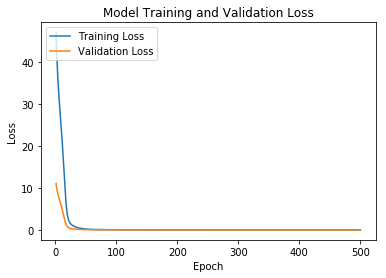

plot saved


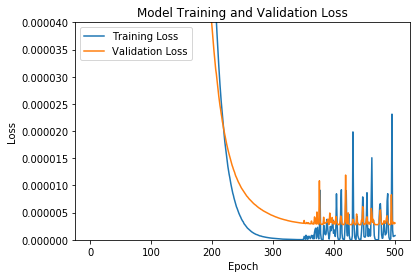

plot saved
dataframe saved
Finished!


In [9]:
# train the model
run_training(model=model, modelpath=model_path, figpath=fig_path, fig2path = fig2_path, dfpath=df_path, trainset=trainset, 
      validsize=valid_size, numepochs=n_epochs, batchsize=batch_size, seed=seed)

print('Finished!')

In [10]:
list(model.parameters())

[Parameter containing:
 tensor([[-4.9883e-01,  1.1425e-03,  3.5857e-02],
         [ 6.4632e-02,  5.1962e-01, -1.1222e-01],
         [-6.6983e-03,  9.0265e-06,  3.4863e-01],
         [ 2.5110e-02,  5.6401e-02, -5.1973e-01],
         [ 3.3582e-01, -3.8389e-01,  1.6560e-01],
         [-1.2614e-02, -2.5030e-01, -5.6703e-01]]), Parameter containing:
 tensor([ 0.9184,  1.1226,  0.6139, -0.0650,  1.3910,  1.3892]), Parameter containing:
 tensor([[-1.4938e+00,  4.6621e-01, -1.0722e-01, -3.4625e-06,  6.6481e-01,
          -5.8510e-02],
         [-5.2632e-02,  1.4306e+00, -9.5933e-02, -4.7937e-06, -3.7248e-01,
          -4.5424e-01],
         [ 2.7383e-01, -1.8461e-01,  9.0757e-01,  3.4712e-05,  4.2153e-01,
          -1.0285e+00]]), Parameter containing:
 tensor([ 0.0709, -0.3496,  0.2413])]

## Test Vector

In [11]:
testvec = np.array([0.5,0.5,0.5])

# standardize the input vector
npfile = np.load(infile)
inputs = npfile['inputs']
    
inputMeans = inputs[0:int(inputs.shape[0]),:].mean(axis=0)
inputStdDevs = inputs[0:int(inputs.shape[0]),:].std(axis=0)
test_input = (testvec-inputMeans)/inputStdDevs
test_input = torch.tensor(test_input).float()

# put standardized input vector through model
model.eval()
test_output = model(test_input)
test_output = test_output.detach().numpy()

# unstandardizing the output
npfile = np.load(infile)
outputs = npfile['outputs']
    
outputMeans = outputs[0:int(outputs.shape[0]),:].mean(axis=0)
outputStdDevs = outputs[0:int(outputs.shape[0]),:].std(axis=0)
    
test_result = (test_output*outputStdDevs)+outputMeans

print('model output = {}'.format(test_result))

# compare to target output
print('target output = {}'.format(testvec))

# measure accuracy
diff = np.linalg.norm(testvec - test_result)
mag = np.linalg.norm(testvec)
error = (diff/mag)*100
acc = 100 - error
print('error = {}%'.format(error))
print('accuracy = {}%'.format(acc))

model output = [0.50269461 0.49997738 0.50055842]
target output = [0.5 0.5 0.5]
error = 0.31776911467877933%
accuracy = 99.68223088532122%
